**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.nlp import *
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from torchtext import vocab, data, datasets
import pandas as pd

In [ ]:
sl=1000
vocab_size=200000

In [ ]:
PATH='data/arxiv/arxiv.csv'

# You can download a similar to Jeremy's original arxiv.csv here: https://drive.google.com/file/d/0B34BjUTAgwm6SzdPWDAtVG1vWVU/. It comes from this article https://hackernoon.com/building-brundage-bot-10252facf3d1 and github https://github.com/amauboussin/arxiv-twitterbot, just rename it to arxiv.csv

df = pd.read_csv(PATH)
df.head()

,link,time,favorites,rts,authors,category,published,summary,title,tweeted
0,arxiv.org/abs/1611.10003,NaN,NaN,NaN,"[Tom A. F. Anderson, C. -H. Ruan]",q-bio.NC,2016-11-30 05:17:11,In summary of the research findings presented ...,Vocabulary and the Brain: Evidence from Neuroi...,0
1,arxiv.org/abs/1611.10007,NaN,NaN,NaN,"[M. Amin Rahimian, Amir G. Aghdam]",cs.SY,2016-11-30 05:37:11,"In this paper, structural controllability of a...",Structural Controllability of Multi-Agent Netw...,0
2,arxiv.org/abs/1611.10010,NaN,NaN,NaN,"[Debidatta Dwibedi, Tomasz Malisiewicz, Vijay ...",cs.CV,2016-11-30 06:00:47,We present a Deep Cuboid Detector which takes ...,Deep Cuboid Detection: Beyond 2D Bounding Boxes,0
3,arxiv.org/abs/1611.10012,2016-12-01 01:46:12,11.0,2.0,"[Jonathan Huang, Vivek Rathod, Chen Sun, Mengl...",cs.CV,2016-11-30 06:06:15,"In this paper, we study the trade-off between ...",Speed/accuracy trade-offs for modern convoluti...,1
4,arxiv.org/abs/1611.10014,NaN,NaN,NaN,"[Yoones Hashemi, Amir H. Banihashemi]",cs.IT,2016-11-30 06:12:45,"In this paper, we propose a characterization o...",Characterization and Efficient Exhaustive Sear...,0


In [ ]:
df['txt'] = df.category + ' ' + df.title + '\n' + df.summary

In [ ]:
print(df.iloc[0].txt)

q-bio.NC Vocabulary and the Brain: Evidence from Neuroimaging Studies
In summary of the research findings presented in this paper, various brain
regions are correlated with vocabulary and vocabulary acquisition. Semantic
associations for vocabulary seem to be located near brain areas that vary
according to the type of vocabulary, e.g. ventral temporal regions important
for words for things that can be seen. Semantic processing is believed to be
strongly associated with the ANG. Phonological ability has been closely related
to the anterior surfaces of the SMG. Pathways through the posterior SMG are
thought to link the anterior SMG and the ANG. In vocabulary tasks,
mediotemporal structures may be related to long-term memory processing, with
left hippocampal and parahippocampal regions related to long-term and working
memory, respectively. Precentral structures are associated with phonological
retrieval. Furthermore, many more regions of the brain are of interest in
vocabulary tasks, part

In [ ]:
n=len(df); n

27188

In [ ]:
val_idx = get_cv_idxs(n, val_pct=0.1)
((val,trn),(val_y,trn_y)) = split_by_idx(val_idx, df.txt.values, df.tweeted.values)

## Ngram logistic regression

In [ ]:
veczr =  CountVectorizer(ngram_range=(1,3), tokenizer=tokenize)
trn_term_doc = veczr.fit_transform(trn)
val_term_doc = veczr.transform(val)
trn_term_doc.shape, trn_term_doc.sum()

((24470, 3780668), 14938443)

In [ ]:
y=trn_y
x=trn_term_doc.sign()
val_x = val_term_doc.sign()

In [ ]:
p = x[np.argwhere(y!=0)[:,0]].sum(0)+1
q = x[np.argwhere(y==0)[:,0]].sum(0)+1
r = np.log((p/p.sum())/(q/q.sum()))
b = np.log(len(p)/len(q))

In [ ]:
pre_preds = val_term_doc @ r.T + b
preds = pre_preds.T>0
(preds==val_y).mean()

0.80316409124356147

In [ ]:
m = LogisticRegression(C=0.1, fit_intercept=False)
m.fit(x, y);

preds = m.predict(val_x)
(preds.T==val_y).mean()

0.85062545989698313

In [ ]:
probs = m.predict_proba(val_x)[:,1]

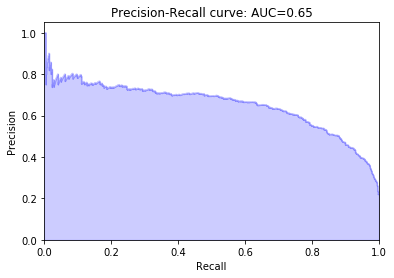

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(val_y, probs)
average_precision = average_precision_score(val_y, probs)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(average_precision));

In [ ]:
recall[precision>=0.6][0]

0.7583187390542907

In [ ]:
df_val = df.iloc[sorted(val_idx)]

In [ ]:
incorrect_yes = np.where((preds != val_y) & (val_y == 0))[0]
most_incorrect_yes = np.argsort(-probs[incorrect_yes])
txts = df_val.iloc[incorrect_yes[most_incorrect_yes[:10]]]
txts[["link", "title", "summary"]]

In [ ]:
' '.join(txts.link.values)

'arxiv.org/abs/1710.00814 arxiv.org/abs/1612.02559 arxiv.org/abs/1708.00489 arxiv.org/abs/1703.11000 arxiv.org/abs/1612.06704 arxiv.org/abs/1708.00973 arxiv.org/abs/1707.07341 arxiv.org/abs/1707.06728 arxiv.org/abs/1710.02318 arxiv.org/abs/1612.01064'

In [ ]:
incorrect_no = np.where((preds != val_y) & (val_y == 1))[0]
most_incorrect_no = np.argsort(probs[incorrect_no])
txts = df_val.iloc[incorrect_no[most_incorrect_no[:10]]]

In [ ]:
txts[["link", "title", "summary"]]

,link,title,summary
18571,arxiv.org/abs/1707.03243,Malware in the Future? Forecasting Analyst Det...,"Cyber attacks endanger physical, economic, soc..."
23392,arxiv.org/abs/1709.00765,Number of hidden states needed to physically i...,We consider the problem of implementing a give...
18419,arxiv.org/abs/1707.02651,Model-Based Speech Enhancement in the Modulati...,This paper presents algorithms for modulation-...
10414,arxiv.org/abs/1704.02162,Locally-adapted convolution-based super-resolu...,Super-resolution is a classical problem in ima...
3976,arxiv.org/abs/1701.07381,Design and Implementation of a Semantic Dialog...,This chapter describes a semantic dialogue sys...
13229,arxiv.org/abs/1705.04824,Extracting urban impervious surface from GF-1 ...,Impervious surface area is a direct consequenc...
18308,arxiv.org/abs/1707.02279,A Probabilistic Calculus of Cyber-Physical Sys...,We propose a hybrid probabilistic process calc...
18368,arxiv.org/abs/1707.02477,Hyperspectral Image Restoration via Total Vari...,Hyperspectral images (HSIs) are often corrupte...
22275,arxiv.org/abs/1708.06248,GraphR: Accelerating Graph Processing Using ReRAM,"This paper presents GRAPHR, the first ReRAM-ba..."
17840,arxiv.org/abs/1707.00506,Recommender System for News Articles using Sup...,In the last decade we have observed a mass inc...


In [ ]:
' '.join(txts.link.values)

'arxiv.org/abs/1707.03243 arxiv.org/abs/1709.00765 arxiv.org/abs/1707.02651 arxiv.org/abs/1704.02162 arxiv.org/abs/1701.07381 arxiv.org/abs/1705.04824 arxiv.org/abs/1707.02279 arxiv.org/abs/1707.02477 arxiv.org/abs/1708.06248 arxiv.org/abs/1707.00506'

In [ ]:
to_review = np.where((preds > 0.8) & (val_y == 0))[0]
to_review_idx = np.argsort(-probs[to_review])
txts = df_val.iloc[to_review[to_review_idx]]

In [ ]:
txt_html = ('<li><a href="http://' + txts.link + '">' + txts.title.str.replace('\n',' ') + '</a>: ' 
    + txts.summary.str.replace('\n',' ') + '</li>').values

In [ ]:
full_html = (f"""<!DOCTYPE html>
<html>
<head><title>Brundage Bot Backfill</title></head>
<body>
<ul>
{os.linesep.join(txt_html)}
</ul>
</body>
</html>""")

## Learner

In [ ]:
veczr = CountVectorizer(ngram_range=(1,3), tokenizer=tokenize, max_features=vocab_size)

trn_term_doc = veczr.fit_transform(trn)
val_term_doc = veczr.transform(val)

In [ ]:
trn_term_doc.shape, trn_term_doc.sum()

((24470, 200000), 10271515)

In [ ]:
md = TextClassifierData.from_bow(trn_term_doc, trn_y, val_term_doc, val_y, sl)

In [ ]:
learner = md.dotprod_nb_learner(r_adj=20)

In [ ]:
learner.fit(0.02, 4, wds=1e-6, cycle_len=1)

A Jupyter Widget

/home/jhoward/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


[ 0.       0.13796  0.17713  0.84782  0.68941]
[ 1.       0.11556  0.17372  0.85     0.72286]               
[ 2.       0.09147  0.17366  0.84714  0.72249]                
[ 3.       0.08243  0.17359  0.84646  0.73789]                



In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_at_6(preds,targs):
    precision, recall, _ = precision_recall_curve(targs[:,1], preds[:,1])
    return recall[precision>=0.6][0]

In [ ]:
prec_at_6(*learner.predict_with_targs())

0.71103327495621715